In [45]:
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Three features of the image are collected.
    1) Sharpness ratio.
    2) Variance of the Laplacian of the greyscale image.
    3) Pixel difference.


In [47]:
def get_features(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    edges = cv2.Canny(img, 175, 225)
    sharpness_ratio = np.count_nonzero(edges) * 1000.0 / (edges.shape[0] * edges.shape[1])
    
    height, width = img.shape
    total_diff = sum(
        abs(int(img[y, x]) - int(img[y, x + 1]))
        for x in range(width - 1)
        for y in range(height)
    )
    pixel_diff =  total_diff / (height * width)
    
    return sharpness_ratio, laplacian_var, pixel_diff

# get_features(r'C:\Users\neham\OneDrive\Documents\Digio_assignment\third_assignment\Images_Data\blur\2_XIAOMI-PROCOFONE-F1_M.jpg')

In [4]:
# def get_features(image_path):
#     img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
#     edges = cv2.Canny(img, 175, 225)
#     sharpness_ratio = np.count_nonzero(edges) * 1000.0 / (edges.shape[0] * edges.shape[1])
    
#     height, width = img.shape
#     total_diff = sum(
#         abs(int(img[y, x]) - int(img[y, x + 1]))
#         for x in range(width - 1)
#         for y in range(height)
#     )
#     pixel_diff =  total_diff / (height * width)
    
#     return sharpness_ratio, np.std(img), pixel_diff


In [ ]:
#collect data and features.
path = './Images_Data/sharp/'
sharp_var_lst = []

for filename in tqdm(os.listdir(path)):
    sharpness, laplac_var, pixel_diff  = get_features(path + filename)
    feature = np.array([sharpness, laplac_var, pixel_diff])
    sharp_var_lst.append(feature)

sharp_var_lst = np.array(sharp_var_lst)
sharp_var_lst

100%|██████████| 2300/2300 [10:43<00:00,  3.57it/s]


array([[ 17.33493805, 247.41364025,   2.44966189],
       [  2.71648924,  99.48899596,   1.74437815],
       [  1.99819712, 125.51331887,   2.61158604],
       ...,
       [ 41.37695312, 345.4631025 ,   4.9705306 ],
       [  5.21484375, 331.13593714,   3.77116211],
       [  5.94075521, 301.20009528,   3.62240234]])

In [49]:
path = './Images_Data/blur/'
blur_var_lst = []

for filename in tqdm(os.listdir(path)):
    sharpness, laplac_var, pixel_diff  = get_features(path + filename)
    feature = np.array([sharpness, laplac_var, pixel_diff])
    blur_var_lst.append(feature)

blur_var_lst = np.array(blur_var_lst)


100%|██████████| 1770/1770 [15:53<00:00,  1.86it/s] 


### Build an SVM model on the data to classify the images.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Example data (replace with your actual arrays)
blured_images = blur_var_lst  # Shape (n_samples, 3)
sharp_images = sharp_var_lst  # Shape (n_samples, 3)

# Step 1: Combine the data and label them
X = np.vstack((blured_images, sharp_images))  # Features
y = np.hstack((np.zeros(len(blured_images)), np.ones(len(sharp_images))))  # Labels: 0 for blurred, 1 for sharp

# Step 2: Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the SVM model
svm_model = SVC(kernel='linear')  
# svm_model=SVC(kernel='rbf', C=1, gamma=0.5)
svm_model.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.82


In [51]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 6: Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Optional: Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[315  61]
 [ 82 356]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82       376
         1.0       0.85      0.81      0.83       438

    accuracy                           0.82       814
   macro avg       0.82      0.83      0.82       814
weighted avg       0.83      0.82      0.82       814



In [52]:
# Step 4: Make predictions on the train set
y_pred = svm_model.predict(X_train)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_train, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.83


### Plot of the data with the SVM hyperplane.

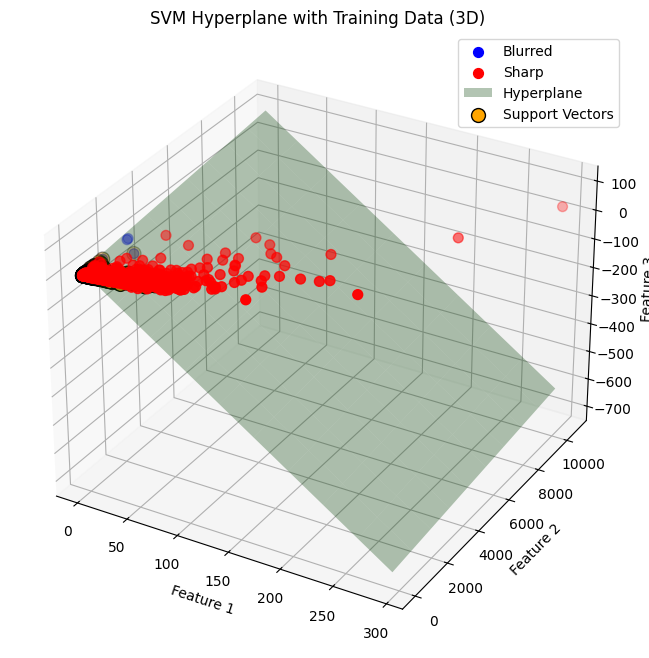

In [53]:
# Get the hyperplane coefficients
w = svm_model.coef_[0]  # Coefficients of the hyperplane
b = svm_model.intercept_[0]  # Intercept of the hyperplane

# Create a grid for plotting the hyperplane
x = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 10)
y = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 10)
x_grid, y_grid = np.meshgrid(x, y)
z_grid = -(w[0] * x_grid + w[1] * y_grid + b) / w[2]  # Solve for z

# Plot the 3D data points and hyperplane
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points
ax.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], X_train[y_train == 0][:, 2], 
           color='blue', label='Blurred', s=50)
ax.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], X_train[y_train == 1][:, 2], 
           color='red', label='Sharp', s=50)

# Plot the hyperplane
ax.plot_surface(x_grid, y_grid, z_grid, color='green', alpha=0.3, label='Hyperplane')

# Plot the support vectors
ax.scatter(svm_model.support_vectors_[:, 0], svm_model.support_vectors_[:, 1], svm_model.support_vectors_[:, 2], 
           color='orange', edgecolor='k', label='Support Vectors', s=100)

# Customize the plot
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.set_title('SVM Hyperplane with Training Data (3D)')
ax.legend()
plt.show()

### Applying Ensemble Learning technique and compare the result with Logistic Regression, KNN, Decision Tree, Random_forest, Voting Classifier

In [54]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

In [55]:
# Define individual classifiers
logistic_clf = LogisticRegression(random_state=42)
knn_clf = KNeighborsClassifier(n_neighbors=5)
random_forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
decision_tree_clf = DecisionTreeClassifier(random_state=42)
svm_clf = SVC(kernel='rbf', C=1, gamma=0.5, probability=True, random_state=42)  # Enable probability for VotingClassifier

# Create an ensemble model using VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[
        ('logistic', logistic_clf),
        ('knn', knn_clf),
        ('random_forest', random_forest_clf),
        ('decision_tree', decision_tree_clf),
        ('svm', svm_clf)
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Train the ensemble model
ensemble_clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble_clf.predict(X_test)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, y_pred)
print(f'Ensemble Model Accuracy: {accuracy:.2f}')

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


# Evaluate individual models
for name, clf in ensemble_clf.named_estimators_.items():
    clf.fit(X_train, y_train)
    y_pred_individual = clf.predict(X_test)
    acc_individual = accuracy_score(y_test, y_pred_individual)
    print(f'{name.capitalize()} Accuracy: {acc_individual:.2f}')

Ensemble Model Accuracy: 0.82
Confusion Matrix:
[[291  85]
 [ 60 378]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.77      0.80       376
         1.0       0.82      0.86      0.84       438

    accuracy                           0.82       814
   macro avg       0.82      0.82      0.82       814
weighted avg       0.82      0.82      0.82       814

Logistic Accuracy: 0.82
Knn Accuracy: 0.82
Random_forest Accuracy: 0.83
Decision_tree Accuracy: 0.76
Svm Accuracy: 0.81


## Applying Random Forest
##### Accuracy vs. Number of Trees: Tracks training and testing accuracy as the model complexity increases.
##### Log Loss vs. Number of Trees: Tracks training and testing loss as the model complexity

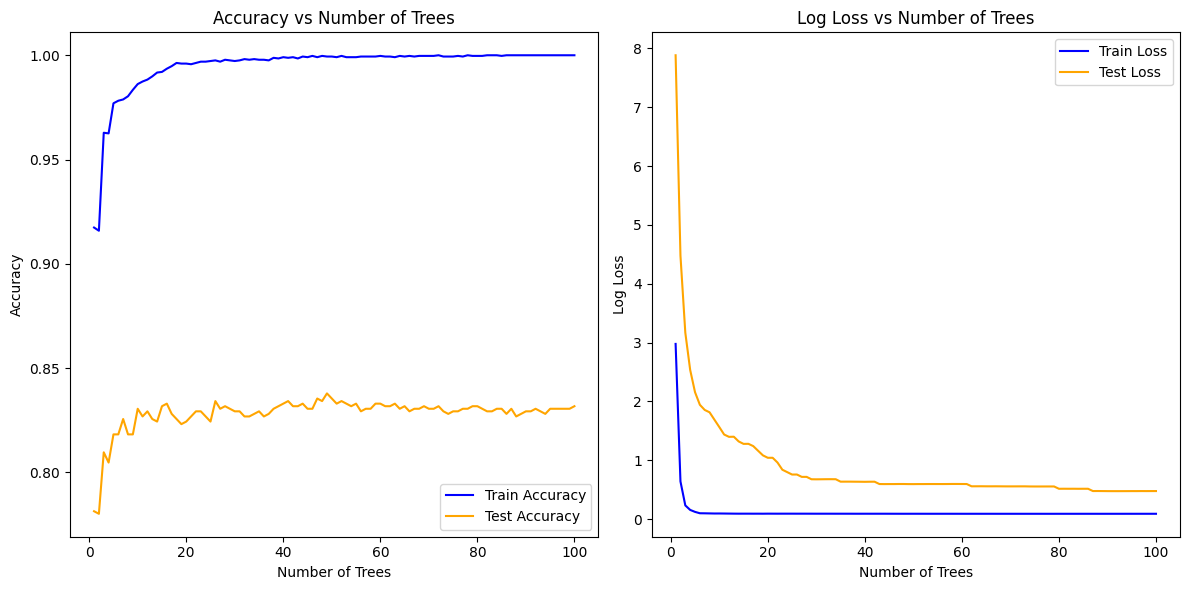

In [56]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier

# Train the model and track loss and accuracy over iterations
clf = RandomForestClassifier(n_estimators=100, random_state=42, warm_start=True)  # Enable warm_start for incremental training

train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

for n_trees in range(1, 101):  # Incrementally add trees
    clf.set_params(n_estimators=n_trees)
    clf.fit(X_train, y_train)
    
    # Predictions
    train_probs = clf.predict_proba(X_train)
    test_probs = clf.predict_proba(X_test)
    
    # Compute accuracy
    train_accuracies.append(accuracy_score(y_train, clf.predict(X_train)))
    test_accuracies.append(accuracy_score(y_test, clf.predict(X_test)))
    
    # Compute log loss
    train_losses.append(log_loss(y_train, train_probs))
    test_losses.append(log_loss(y_test, test_probs))

# Plot the results
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(range(1, 101), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, 101), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(range(1, 101), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, 101), test_losses, label='Test Loss', color='orange')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('Log Loss vs Number of Trees')
plt.legend()

plt.tight_layout()
plt.show()